In [1]:
import numpy as np
from numpy import dot
import random
import math
import time
import matplotlib.pyplot as plt 


## 1.读取处理数据

In [2]:
#生成评分数组
def gen_rating_matrix(path):
    rdlt = read_raw_data(path)
    r_matrix = gen_matrix(rdlt)
    return r_matrix

#获取原始TXT数据，并处理成可分部分读取的
def read_raw_data(path):
    rd = open(path,'r')
    rd_list = rd.readlines()
    
    #建立分割好的列表（可范围每一行的元素）
    rd_list_treated = []
    for i in range(len(rd_list)):
        rd_tmp = rd_list[i].split('\t')
        rd_list_treated.append(rd_tmp)
    rd.close()
    
    return rd_list_treated

#根据TXT数据，生成评分数组
def gen_matrix(rd_list_treated):
    rdlt = rd_list_treated
    
    #初始化评分矩阵,空的评分，将视为0
    rating_matrix = np.zeros((num_users, num_movies))
    for i in range(len(rdlt)):
        r_users = int(rdlt[i][0]) - 1
        r_movies = int(rdlt[i][1]) - 1
        rate = int(rdlt[i][2])
        
        rating_matrix[r_users][r_movies] = rate
    
    return rating_matrix


## 2.建立分拆矩阵模型类

In [3]:
class matrix_factorization:
  
    #我真理解这种算法了，正确的做法中，>0是必要的
    def __init__(self, lamda, P, Q, n_users, n_items, k):
        self.n_u = n_users
        self.n_i = n_items
        self.k = k
        self.lamda = lamda
        
        self.P = P
        self.Q = Q
   
    #我实在是不想用循环，而想用矩阵运算，所以要先做预处理，求出每个用户评论多少电影，
    #以及每个电影有多少个用户评论
    def pretreament(self, rating_matrix):
        n_p_users = []
        n_q_items = []
        r_matrix = rating_matrix
        #先计算用户评价了多少个东西
        for i in range(self.n_u):
            tmp_amount = self.n_i
            for j in range(self.n_i):
                if( r_matrix[i][j] == 0 ):
                    tmp_amount -= 1
            n_p_users.append(tmp_amount)    

        #再计算每个东西有多少个用户评价
        for i in range(self.n_i):
            tmp_amount = self.n_u
            for j in range(self.n_u):
                if( r_matrix[j][i] == 0 ):
                    tmp_amount -= 1
            n_q_items.append(tmp_amount)
        
        return n_p_users, n_q_items

    #train
    def SGD_fit(self, epoch, lr, r_matrix_train, \
                r_matrix_test, train_pre,test_pre, I, I_t, n_comments, n_comments_t):
        R = r_matrix_train
        users, items = R.nonzero()
         
        it_num = []
        train_loss = []
        test_loss = []
        train_rmse = []
        test_rmse = []
        
        #amount = len(users)
        for ep in range(epoch):
            
            print('ep' + str(ep+1) + ' success')
            #print(self.loss(r_matrix_test, test_pre, I_t))
            print(self.loss(r_matrix_train, train_pre, I))
            it_num.append(ep)
            train_loss.append( self.loss(r_matrix_train, train_pre, I) )
            test_loss.append( self.loss(r_matrix_test, test_pre, I_t) )
            train_rmse.append( self.rmse(r_matrix_train, I, n_comments) )
            test_rmse.append( self.rmse(r_matrix_test, I_t, n_comments_t) )
           
            for u,i in zip(users,items): 
                e = R[u][i] - dot(self.P[:,u].T, self.Q[:,i])
                self.P[:,u] += lr * (e * self.Q[:,i] - self.lamda * self.P[:,u]) 
                self.Q[:,i] += lr * (e * self.P[:,u] - self.lamda * self.Q[:,i])
            
            if(ep>0 and abs(train_rmse[ep-1]-train_rmse[ep])<=0.001):
                break
                
            
        return it_num, train_loss, test_loss, train_rmse, test_rmse
            
        
    def ALS_fit(self, epoch, r_matrix_train, \
                r_matrix_test, train_pre, test_pre, I, I_t, n_comments, n_comments_t):
        R = r_matrix_train
        E = np.eye(self.k)
        t_pre = train_pre
        
        it_num = []
        train_loss = []
        test_loss = []
        train_rmse = []
        test_rmse = []
        
        #开始进行交替最小二乘法
        for ep in range(epoch):
            
            print('ep' + str(ep+1) + ' success')
            print(self.loss(r_matrix_train, train_pre, I))
            it_num.append(ep)
            train_loss.append( self.loss(r_matrix_train, train_pre, I) )
            test_loss.append( self.loss(r_matrix_test, test_pre, I_t) )
            train_rmse.append( self.rmse(r_matrix_train, I, n_comments) )
            test_rmse.append( self.rmse(r_matrix_test, I_t, n_comments_t) )
            
            for i in range(self.P.shape[1]):
                if(t_pre[0][i] > 0):
                    Q = I[i] * self.Q

                    self.P[:,i] = \
                    np.asarray( np.mat( (Q.dot(Q.T) + self.lamda *  \
                    t_pre[0][i] * E) ).I ).dot(Q).dot(R[i,:].T)

            I2 = I.T
            for i in range(self.Q.shape[1]):
                if(t_pre[1][i] > 0):
                    P = I2[i] * self.P

                    self.Q[:,i] = \
                    np.asarray( np.mat( (P.dot(P.T) + self.lamda * \
                    t_pre[1][i] * E) ).I ).dot(P).dot(R[:,i])
            
            if(ep>0 and abs(train_rmse[ep-1]-train_rmse[ep])<=0.001):
                break
                    
        return it_num, train_loss, test_loss, train_rmse, test_rmse
        
    #loss function
    def loss(self, rating_matrix, pre, I):
        r_matrix = rating_matrix

        #先求出差值矩阵
        r_matrix_pred = dot(self.P.T, self.Q)
        d_matrix = I * (r_matrix - r_matrix_pred)
        #简单的表达学习
        d_sum = np.sum((d_matrix)**2)
        
        #为了使用矩阵运算，只能分别两个正则化项了，
        #由于矩阵运算，远快于循环，我认为这样能减少计算复杂度,
        #毕竟由m*n次循环，减少为m+n次循环，而且中间可以省去if运算，这个是极慢的
        
        p_sum = 0
        for i in range(self.n_u):
            p = pre[0][i] * self.P[:,i].T.dot(self.P[:,i])
            p_sum += p
        p_sum = self.lamda * p_sum
        
        q_sum = 0
        for i in range(self.n_i):
            q = pre[1][i] * self.Q[:,i].T.dot(self.Q[:,i])
            q_sum += q
        q_sum = self.lamda * q_sum
        
        d_sum += p_sum + q_sum
        
        return 0.5 * d_sum
    
    
    def rmse(self, rating_matrix, I, n_comments):
        r_matrix = rating_matrix

        #先求出差值矩阵
        r_matrix_pred = dot(self.P.T, self.Q)
        d_matrix = I * (r_matrix - r_matrix_pred)
        #简单的表达学习
        d_sum = np.sum((d_matrix)**2)
        
        rmse = math.sqrt(d_sum / n_comments) 
        
        return rmse

## 3.全局变量，以及主脚本

In [4]:
#全局变量，评分用户数量，以及电影数量
num_users = 943
num_movies = 1682
iteration = 50
lamda = 0.3
k = 5
lr = 0.01
n_comments = 80000
n_comments_t = 20000

training...
ep1 success
314379.802885
ep2 success
132189.613585
ep3 success
122784.456683
ep4 success
119022.080439
ep5 success
117272.29046
ep6 success
116432.021977
ep7 success
116019.010432
收敛耗时:
13.904210567474365
drawing,please wait
训练集上的rmse:
0.9448683746164548
验证集上的rmse:
0.988222044452182


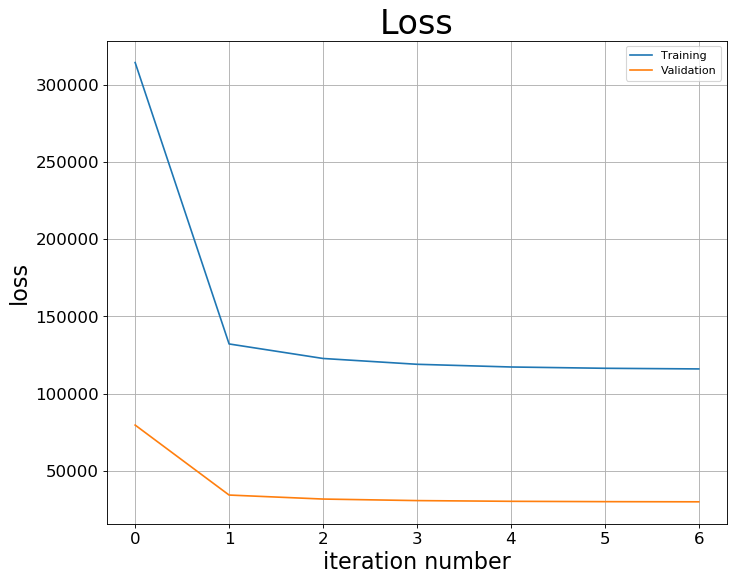

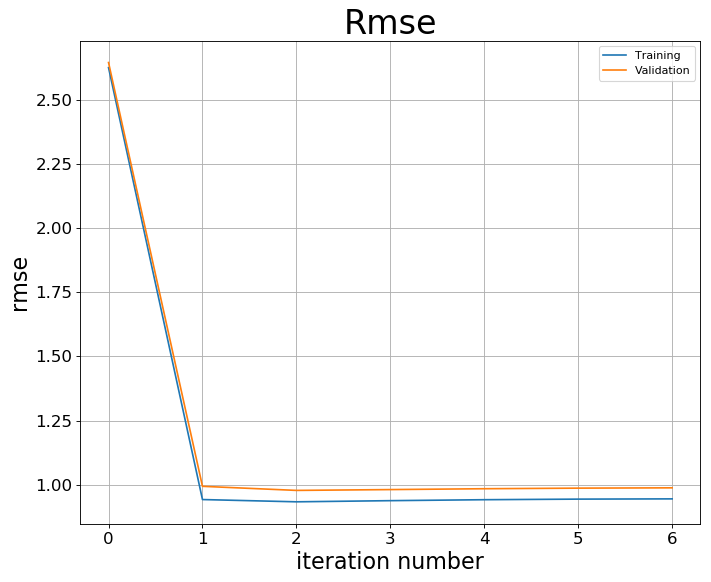

In [6]:
if __name__ == '__main__':
    
    r_matrix_train = gen_rating_matrix('D:\\ML4\\raw_data\\u1.base')
    r_matrix_test = gen_rating_matrix('D:\\ML4\\raw_data\\u1.test')

    np.random.seed(42)
    P = np.random.random((k, num_users))
    np.random.seed(42)
    Q = np.random.random((k, num_movies))
    #P = np.ones((k, num_users))
    #Q = np.ones((k, num_movies))
    #P = np.zeros((k, num_users))
    #Q = np.zeros((k, num_movies))

    m_f = matrix_factorization(lamda, P, Q, num_users, num_movies, k)

    train_pre1,train_pre2 = m_f.pretreament(r_matrix_train)
    test_pre1,test_pre2 = m_f.pretreament(r_matrix_test)
    train_pre = [train_pre1, train_pre2]
    test_pre = [test_pre1, test_pre2]


    #这个矩阵相当重要，新姿势
    I = r_matrix_train.copy()
    I_t = r_matrix_test.copy()
    I[I > 0] = 1
    I[I == 0] = 0
    I_t[I_t > 0] = 1
    I_t[I_t == 0] = 0

    print('training...')
    time_start = time.time()

    it_num, train_loss, test_loss, train_rmse, test_rmse = \
    m_f.ALS_fit(iteration, r_matrix_train, r_matrix_test, \
                train_pre, test_pre, I, I_t, n_comments, n_comments_t)
    '''
    it_num, train_loss, test_loss, train_rmse, test_rmse = \
    m_f.SGD_fit(iteration, lr, r_matrix_train, r_matrix_test, \
                train_pre, test_pre, I, I_t, n_comments, n_comments_t)
    '''
    time_end = time.time()
    print('收敛耗时:')
    print(time_end - time_start)
    #画图了。。。。
    print('drawing,please wait')

    print('训练集上的rmse:')
    print(m_f.rmse(r_matrix_train, I, n_comments))
    print('验证集上的rmse:')
    print(m_f.rmse(r_matrix_test, I_t, n_comments_t))

    plt.figure(figsize=(10,8), dpi=80)
    plt.grid(True)
    plt.title( 'Loss', fontsize=30 )
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel( 'iteration number', fontsize=20 )
    plt.ylabel( 'loss', fontsize=20 )
    plt.plot( it_num, train_loss, label='Training' )
    plt.plot( it_num, test_loss, label='Validation' )  
    plt.legend()

    plt.figure(figsize=(10,8), dpi=80)
    plt.grid(True)
    plt.title( 'Rmse', fontsize=30 )
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel( 'iteration number', fontsize=20 )
    plt.ylabel( 'rmse', fontsize=20 )
    plt.plot( it_num, train_rmse, label='Training' )
    plt.plot( it_num, test_rmse, label='Validation' )  
    plt.legend() 

    plt.show()
